# Re-implementation of GBF in python

In [1]:
import sys
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.io

sys.path.insert(0, '../baselines/gbf')
from gbf_utils import SARBM3D, SoftClassifier, GBF

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[cuda(id=0)]


In [2]:
def T(sar):
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar


def rgb2gray(rgb):
    """Convert RGB image to grayscale."""
    return jnp.dot(rgb[..., :3], jnp.array([1./3.] * 3))

2025-08-21 12:32:55.930077: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


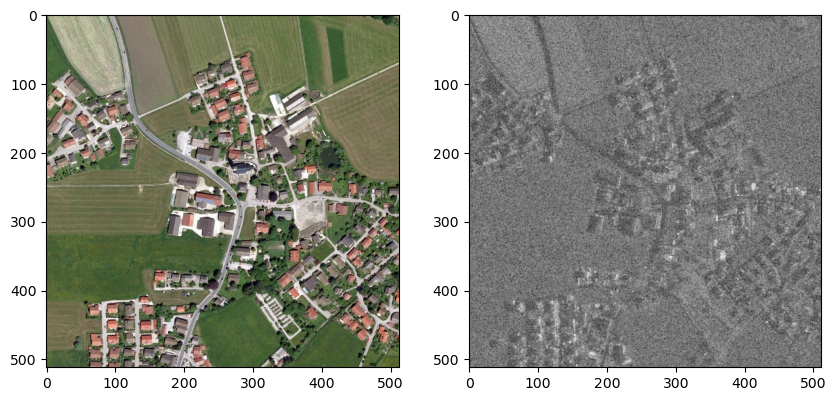

In [3]:
input_path = "../../dataset/clip_T1.mat"
data = scipy.io.loadmat(input_path)

guide = data['guide']
noisy = data['noisy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

### Apply SARBM3D

In [4]:
sarbm3d = SARBM3D(matlab_script_path='./../../SARBM3D_v10_linux64/SARBM3D_v10.m')

sar_filtered_sarbm3d = sarbm3d.filter(noisy, L=1)

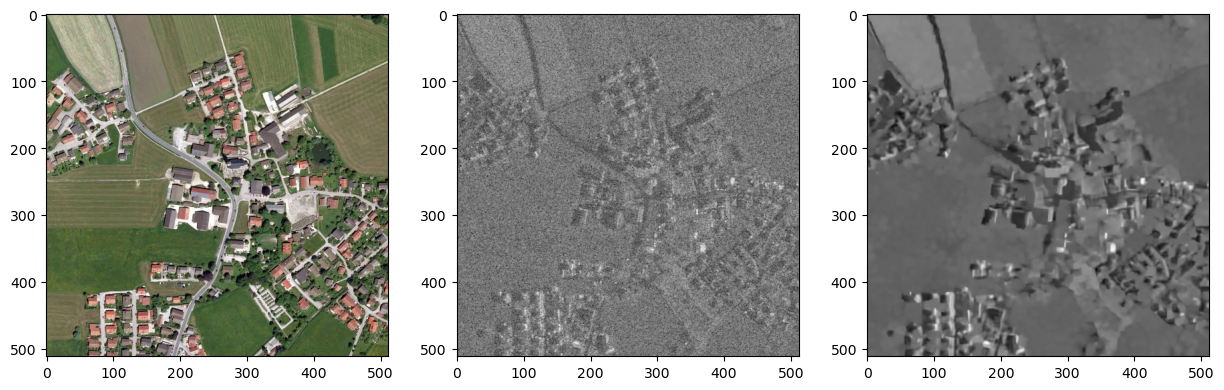

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(T(sar_filtered_sarbm3d), cmap='gray')

### Soft classifier 

In [6]:
soft_classifier = SoftClassifier()

weights = soft_classifier.compute_weight(noisy, N=np.arange(7, 63, 2).tolist())

100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


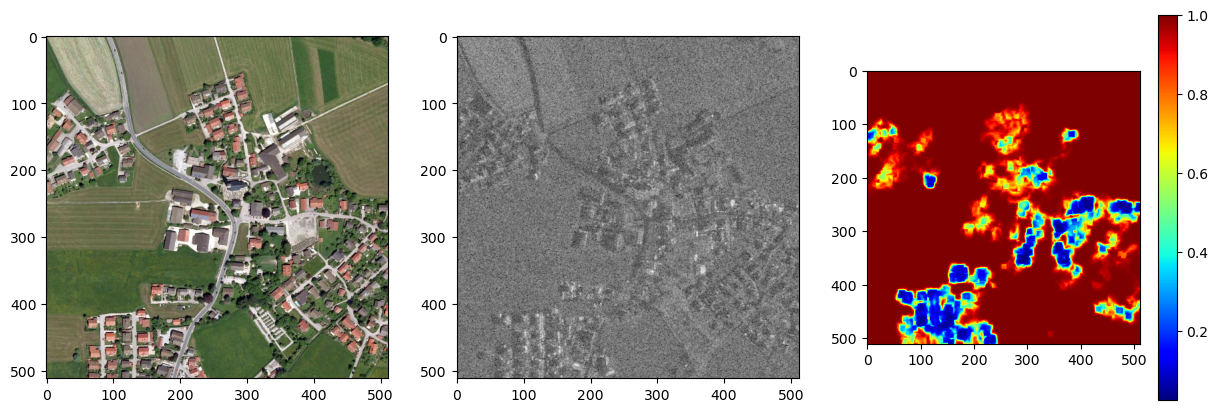

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(weights, cmap='jet')
plt.colorbar()

### GBF

In [8]:
gbf = GBF()

sar_filtered_gbf = gbf.filter(T(noisy).squeeze(), rgb2gray(guide))

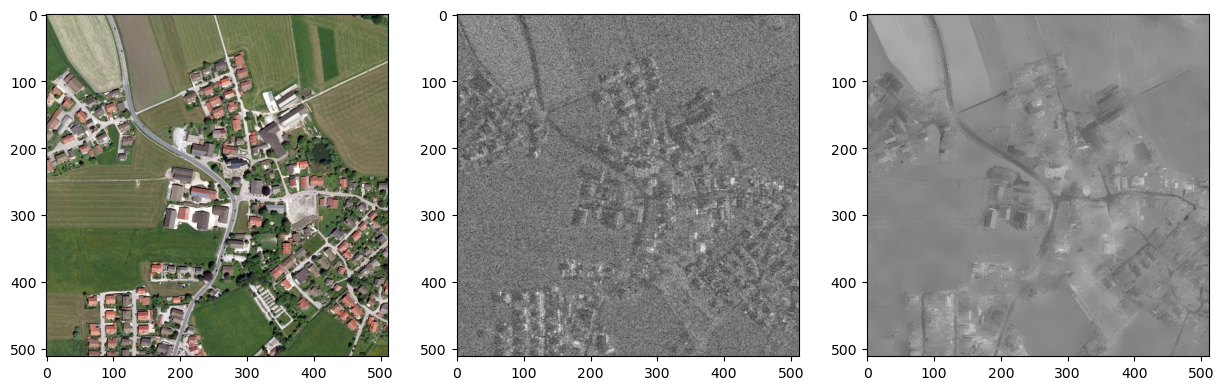

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(guide)
plt.subplot(1, 3, 2)
plt.imshow(T(noisy), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered_gbf, cmap='gray')